# Diurnal effect of low level lapse rate
Steps to get `ds_july_hottest.nc` file required for this Figure:
 * Run `./scripts/load_july_hottest_day.py` on JASMIN

This just takes the month of July for a given, year, looks at the hottest day at each location, and for that day plots the lowest 5 model level bulk lapse rate for the maximum time, and the daily average.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools import cesm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.constants import lapse_dry
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate
import cartopy.crs as ccrs
import os
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

print(os.getcwd())
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs


In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes e.g. gridlines
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
ds = xr.load_dataset(os.path.join(utils.out_dir, 'ds_july_hottest.nc'))
hyam = ds.hyam
hybm = ds.hybm
p0 = float(ds.p0)
lsm = xr.open_dataset(utils.invariant_data_path).LANDFRAC>0.5

### Lapse rate at hottest time of year vs daily average

In [5]:
ds_use = [ds.mean(dim='hour_offset'), ds.isel(hour_offset=ds.TREFHT.argmax(dim='hour_offset'))]
n_level_lapse = 5
for i in range(len(ds_use)):
    ds_use[i]['p'] = cesm.get_pressure(ds_use[i].PS, p0, hyam, hybm)
    ds_use[i]['lapse_low'] = get_bulk_lapse_rate(ds_use[i].T.isel(lev=-1), ds_use[i].T.isel(lev=-n_level_lapse),
                                                 ds_use[i].p.isel(lev=-1), ds_use[i].p.isel(lev=-n_level_lapse))*1000

6.436846887984362
3.2956950507723555
6.311706187862695
3.1720156542259876


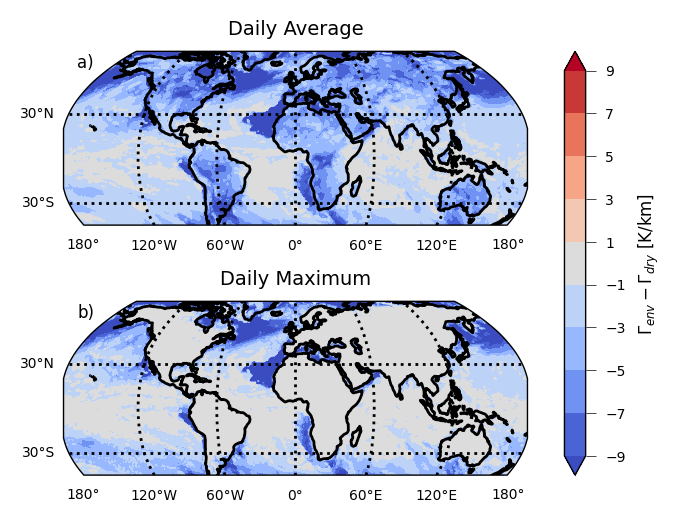

CPU times: user 14.2 s, sys: 211 ms, total: 14.4 s
Wall time: 10.9 s


In [9]:
%%time
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    utils.initialize_ax_projection(ax_use, lat_min=-45, lat_max=75, grid_lat=[-30, 30])
contour_lev = np.linspace(-10, 10, 11)[1:]-1
for i in range(len(ds_use)):
    im = utils.plot_contour_projection(ax[i], ds_use[i].lapse_low - lapse_dry*1000, levels=contour_lev, cmap='coolwarm', mask=None)
    print(float((ds_use[i].lapse_low).where(xr.open_dataset(utils.invariant_data_path).LANDFRAC==0).sel(lat=slice(-45, 75)).weighted(utils.lat_weights).mean()))
    print(float((ds_use[i].lapse_low).where(xr.open_dataset(utils.invariant_data_path).LANDFRAC==0).sel(lat=slice(-45, 75)).weighted(utils.lat_weights).std()))
    # print(float((ds_use[i].lapse_low).where(xr.open_dataset(utils.invariant_data_path).LANDFRAC>0.5).sel(lat=slice(-45, 75)).quantile(0.25)))
    # print(float((ds_use[i].lapse_low).where(xr.open_dataset(utils.invariant_data_path).LANDFRAC>0.5).sel(lat=slice(-45, 75)).quantile(0.75)))
plt.colorbar(im, ax=ax.ravel(), label='$\Gamma_{env} - \Gamma_{dry}$ [K/km]', pad=0.02)
ax[0].set_title('Daily Average')
ax[1].set_title('Daily Maximum')
label_subplots(fig, ax, fontsize=MEDIUM_SIZE, box_alpha=0, pos_y=-1)
plt.show()
# savefig(fig)

In [11]:
lapse_dry*1000

9.75473801560758